In [478]:
import pandas as pd

df = pd.read_csv('data.csv')

In [479]:
# Remove the Timestamp column
df = df.drop(columns=['Timestamp'])

In [480]:
# Rename the columns
df = df.rename(columns={
    "Thank you for your participation. If you want to receive the survey results, enter your email address here. We won't share your email address with anyone, nor send you any ads.": 'email',
    "What's your age?": 'age',
    "What's your gender?": 'gender',
    "Where do you live?": 'homeland',
    "Where do you usually enjoy your holidays? Select all that apply.": 'target',
    "When on vacation, where do you usually stay? Select all that apply.": 'accommodation',
    "Who do you usually enjoy your holidays with? Select all that apply.": 'company',
    "What activities best describe your typical summer vacation? Select all that apply.": 'activities',
    "How do you choose where to go on vacation? Select all that apply.": 'decision',
    "What means of transport do you normally take when going on vacation? Select all that apply.": 'transport',
    "How much did you spend in total during your last summer holidays? Use this format: <cost> <currency> (e.g. 350 €)": 'cost',
    "How much did you enjoy your last summer vacation?": 'enjoyment',
    "Thank you for your participation. If you want to receive the survey results, enter your email address here. We won't share your email address with anyone, nor send you any ads.": 'email',
})

In [481]:
# Extract the email column into a separate array
emails = df['email'].values
# Remove the email column from the dataframe
df = df.drop(columns=['email'])

In [482]:
# Change all the gender values that aren't 'Male' or 'Female' into 'Other'
df['gender'] = df['gender'].apply(lambda x: 'Other' if x != 'Male' and x != 'Female' else x)

In [483]:
# Parse the raw cost values and convert to euros

import re


def assume_eur_if_no_symbol(string):
    try:
        return int(string)
    except ValueError:
        return None


def find_number(string) -> int | None:
    numbers = re.findall(r'\d+', string)

    if len(numbers) == 0:
        return None

    return max([int(x) for x in numbers])


def parse_cost(string: str) -> int | None:
    eur_symbols = ['€', 'eur', 'euro', 'euros']
    usd_symbols = ['$', 'usd', 'dollar', 'dollars']
    gbp_symbols = ['£', 'gbp', 'pound', 'pounds']
    cad_symbols = ['cad']
    aud_symbols = ['aud']
    all_symbols = eur_symbols + usd_symbols + gbp_symbols + cad_symbols + aud_symbols

    string = str(string).lower()

    assume_eur = assume_eur_if_no_symbol(string)

    # Branch based on currency
    if any([x in string for x in eur_symbols]):
        return find_number(string)
    
    if assume_eur is not None:
        return assume_eur

    if any([x in string for x in usd_symbols]):
        n = find_number(string)
        if n is None:
            return None
        return int(n * 1.00)
    
    if any([x in string for x in gbp_symbols]):
        n = find_number(string)
        if n is None:
            return None
        return int(n * 1.15)

    if any([x in string for x in cad_symbols]):
        n = find_number(string)
        if n is None:
            return None
        return int(n * 0.76)
    
    if any([x in string for x in aud_symbols]):
        n = find_number(string)
        if n is None:
            return None
        return int(n * 0.67)


def parse_and_normalize(cost: str) -> int | None:
    cost = str(cost)
    cost = parse_cost(cost)
    if cost is None:
        return None

    if cost > 10000:
        return 10000
    return cost


df['cost'] = df['cost'].apply(parse_and_normalize)


In [484]:
# Normalize the homeland column

def parse_homeland(string) -> str:
    string = str(string).lower()

    europe_substrings = ['europe', 'italia', 'milano', 'israel']
    if any(sub in string for sub in europe_substrings):
        return 'europe'

    north_america_substrings = ['america', 'usa', 'canada']
    if 'south' not in string and any([sub in string for sub in north_america_substrings]):
        return 'north america'
    
    asia_substrings = ['japan', 'china', 'asia', 'india', 'korea', 'singapore', 'thailand', 'vietnam', 'new zealand']
    if any([sub in string for sub in asia_substrings]):
        return 'asia'
    
    normal_countries = ['australia', 'south america', 'africa']
    if any([sub in string for sub in normal_countries]):
        return string

    # Log other homelands
    print(string)

    return string
    

df['homeland'] = df['homeland'].apply(parse_homeland)



In [485]:
# Parse the accomodation column

def parse_accomodation(accomodation) -> str:
    accomodation = str(accomodation).lower()

    normal_accomodations = [
        'hotel or motel',
        'rent a house',
        'family or friend\'s house',
        'camper',
        'tent or hut'
    ]

    if any([x in accomodation for x in normal_accomodations]):
        return accomodation

    if 'rent' in accomodation:
        return 'rent a house'

    if 'hotel' in accomodation:
        return 'hotel or motel'
    
    if accomodation == 'caravan':
        return 'camper'
    
    if 'hostel' in accomodation:
        return 'hostel'

    # Log other accomodations
    print(accomodation)
    
    return accomodation


df['accommodation'] = df['accommodation'].apply(parse_accomodation)

n/a i live near vegas so no sleeping there
cabin
sommarstuga
boat
my house 
village 
resort
nan


In [486]:
# Parse target column

def parse_target(target) -> str:
    target = target.lower()

    normal_targets = [
        'seaside',
        'mountains',
        'lake or river',
        'countryside'
    ]

    if any([x in target for x in normal_targets]):
        return target
    
    city_substrings = ['city', 'town', 'village', 'cities', 'home']
    if any([x in target for x in city_substrings]):
        return 'city'

    print(target)

    return target


df['target'] = df['target'].apply(parse_target)

i go here three times a year for 1 day, and that's it https://www.battlefieldvegas.com/
at my family's house in taiwan
i don't really do holidays; i've been unabole to work for a long time and while i could afford to travel, my anxiety usually prevents me from doing more than the occasional day trip


In [487]:
# Parse company column

def parse_company(company) -> str:
    company = company.lower()

    normal_companies = [
        'family',
        'friends',
        'boyfriend/girlfriend',
        'alone'
    ]

    if company == 'boyfriend/girlfriend' or 'partner' in company:
        return 'partner'

    if any([x in company for x in normal_companies]):
        return company

    print(company)

    return company


df['company'] = df['company'].apply(parse_company)

In [488]:
# Parse the transport column

def parse_transport_name(transport) -> str:

    normal_transports = [
        'car',
        'train',
        'airplane',
        'bus or taxi'
    ]

    if any([x in transport for x in normal_transports]):
        return transport
    
    if 'subway' in transport:
        return 'train'

    if 'plane' in transport:
        return 'airplane'
    
    bus_substrings = ['bus', 'taxi', 'uber', 'coach']
    if 'bus' in transport:
        return 'bus or taxi'
    
    boat_substrings = ['boat', 'ship', 'ferry']
    if any([x in transport for x in boat_substrings]):
        return 'boat'

    print(transport)

    return transport


def parse_transport(transports) -> str:
    transports = map(lambda x: x.lower().strip(), transports.split(';'))

    transports = map(lambda x: parse_transport_name(x), transports)

    return ';'.join(transports)
    


df['transport'] = df['transport'].apply(parse_transport)

coach
bycicle
uber


In [489]:
# Parse the age column into ranges

def parse_age(age) -> str:
    
    if age == 'Less than 14 years old':
        return '<14'
    if age == '14 - 16 years old':
        return '14-16'
    if age == '16 - 18 years old':
        return '16-18'
    if age == '18 - 25 years old':
        return '18-25'
    if age == 'More than 25 years old':
        return '>25'
    

df['age'] = df['age'].apply(parse_age)

In [490]:
# Parse the activities

def parse_activity_name(activity) -> str:

    normal_activities = [
        'going to the beach',
        'trekking or walking',
        'visiting museums and cultural sites',
        'extreme sports',
        'working',
        'travelling, visiting cities and places of interest',
        'staying at home',
        'cruise',
        'camping',
        'attending concerts or live events (e.g. football match)'
    ]

    if any([x in activity for x in normal_activities]):
        return activity
    
    events_substrings = ['concert', 'match', 'event', 'party', 'club']
    if any([x in activity for x in events_substrings]):
        return 'attending concerts or live events (e.g. football match)'
    
    beach_substrings = ['swimming', 'sunbathing', 'playing in the sand']
    if any([x in activity for x in beach_substrings]):
        return 'going to the beach'

    trekking_substrings = ['trekking', 'walking', 'hiking', 'mountain']
    if any([x in activity for x in trekking_substrings]):
        return 'trekking or walking'

    visiting_substrings = ['visiting', 'tour', 'sightseeing', 'bar', 'shop']
    if any([x in activity for x in visiting_substrings]):
        return 'visiting museums and cultural sites'
    
    sailing_substrings = ['sail', 'yacht', 'boat', 'surf', 'canoe', 'kayak']
    if any([x in activity for x in sailing_substrings]):
        return 'sailing'

    relaxing_substrings = ['relax', 'chill', 'rest', 'sleep', 'read', 'nature', 'fish']
    if any([x in activity for x in relaxing_substrings]):
        return 'relaxing'

    print(activity)

    return activity


def parse_activities(activities) -> str:
    activities = str(activities)

    activities = map(lambda x: x.lower().strip(), activities.split(';'))

    activities = map(lambda x: parse_activity_name(x), activities)

    return ';'.join(activities)


df['activities'] = df['activities'].apply(parse_activities)



full auto shooting (i'm into firearms and shoot everyday on my own, but only own semiauto rifles)
studio
nan
trying new cuisine
n/a (only been on vacation in my childhood)


In [491]:
# Parse the deicsion column

def parse_decision_name(decision) -> str:

    normal_decisions = [
        'i have friends there',
        'my relatives live there',
        'i want to visit a certain place',
        'i always go there on vacation, it\'s a tradition',
        'i have a house there'
    ]

    if any([x in decision for x in normal_decisions]):
        return decision

    want_substrings = ['nice', 'agree', 'group', 'partner', 'plan', 'interesting', 'good']
    if any([x in decision for x in want_substrings]):
        return 'i want to visit a certain place'
    
    near_substrings = ['near', 'close', 'close to', 'far', 'nice', 'distance', 'cheap', 'price', 'avail', 'afford', 'budget']
    if any([x in decision for x in near_substrings]):
        return 'near and cheap'
    
    parents_substrings = ['parent', 'someone else', 'decides', 'chooses', 'takes me', 'am not']
    if any([x in decision for x in parents_substrings]):
        return 'someone else decides'

    print(decision)

    return decision


def parse_decisions(decisions) -> str:
    decisions = str(decisions).lower()

    decisions = map(lambda x: x.lower().strip(), decisions.split(';'))

    decisions = map(lambda x: parse_decision_name(x), decisions)

    return ';'.join(decisions)


df['decision'] = df['decision'].apply(parse_decisions)


by doing research
people’s recommendations
warm weather/beach
i choose places with tropical climate
sometims i visit my sister for a few days who lives in a different city, but i don#t really view it as a vacation


age
<14              NaN
14-16    1260.833333
16-18    1541.250000
18-25    1174.712329
>25      1680.561983
Name: cost, dtype: float64


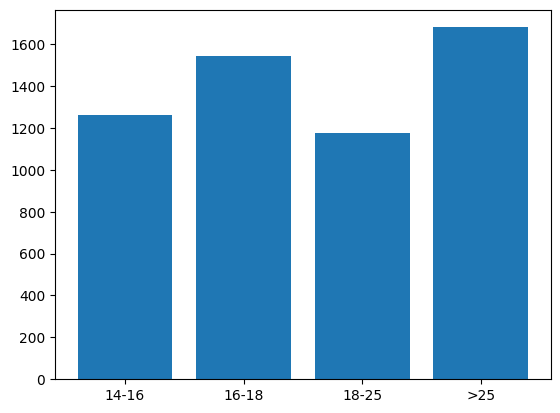

In [492]:
# Calculate average cost for each age range

# people after 18 stop getting money from their parents, so they have a smaller budget
# people 14-16 have a smaller budget because they are still too young to do much on their own
# people 16-18 have the highest budget because they are quite independent and their parents pay for them

costs = df.groupby('age')['cost'].mean()

# Reorder the costs so that the age ranges are in the correct order
costs = costs.reindex(['<14', '14-16', '16-18', '18-25', '>25'])

# Plot the average cost for each age range
import matplotlib.pyplot as plt

print(costs)

plt.bar(costs.index, costs.values)
plt.show()


homeland
asia             3600.000000
north america    1606.856000
south america    1380.000000
europe           1181.088608
australia         889.857143
africa                   NaN
Name: cost, dtype: float64


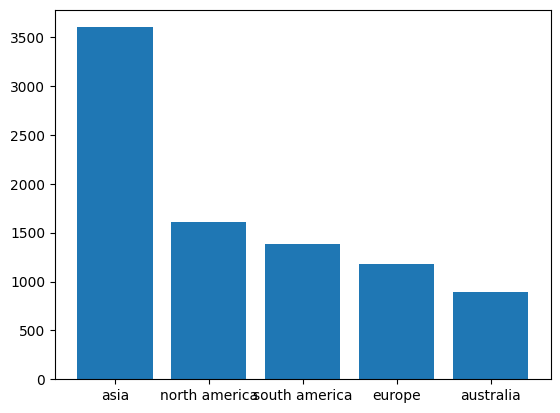

In [493]:
# Average cost for each homeland

cost_per_land = df.groupby('homeland')['cost'].mean()

# Sort from highest to lowest
cost_per_land = cost_per_land.sort_values(ascending=False)

import matplotlib.pyplot as plt

print(cost_per_land)

plt.bar(cost_per_land.index, cost_per_land.values)
plt.show()


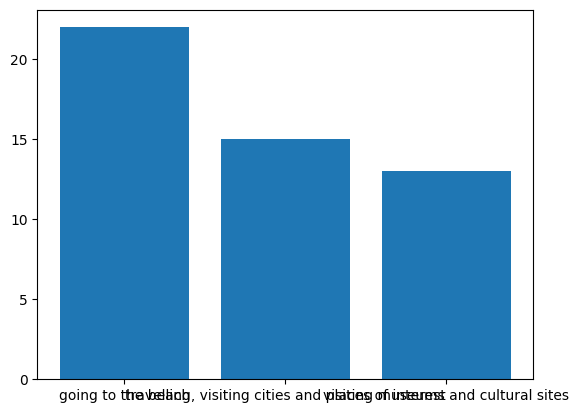

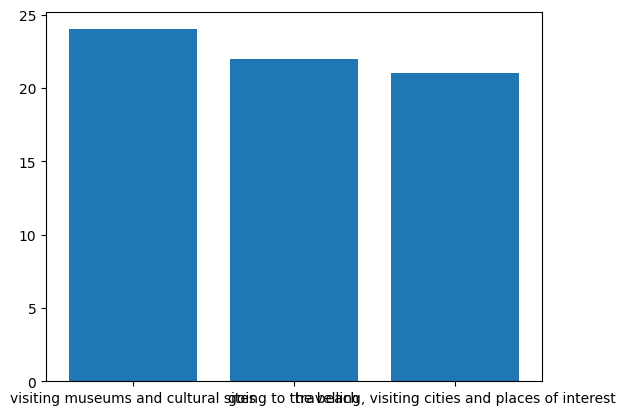

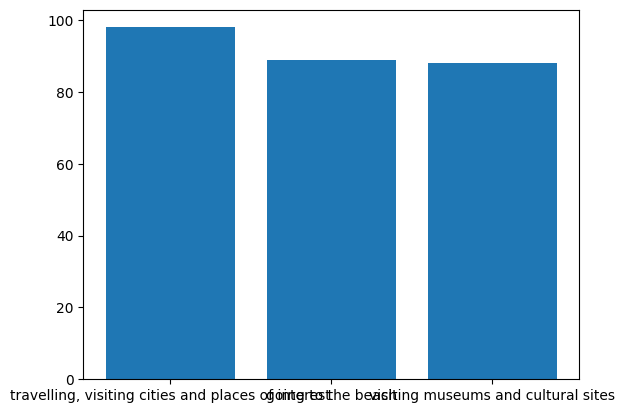

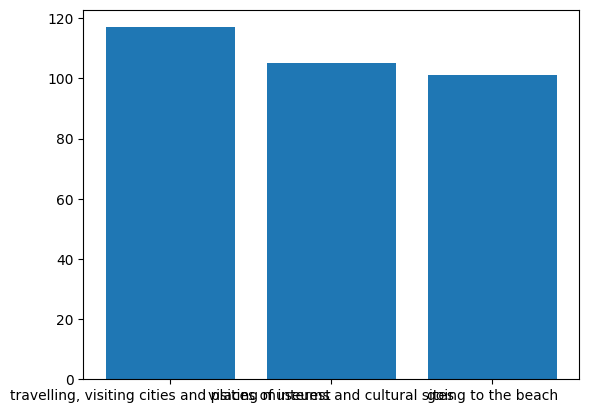

,going to the beach,"travelling, visiting cities and places of interest",visiting museums and cultural sites,trekking or walking,staying at home,attending concerts or live events (e.g. football match),extreme sports,camping,working,cruise,sailing,studio,relaxing,"full auto shooting (i'm into firearms and shoot everyday on my own, but only own semiauto rifles)",n/a (only been on vacation in my childhood),nan,trying new cuisine
age,,,,,,,,,,,,,,,,,
14-16,22.0,15.0,13.0,9.0,8.0,4.0,3.0,3.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16-18,22.0,21.0,24.0,10.0,13.0,9.0,2.0,1.0,4.0,8.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
18-25,89.0,98.0,88.0,74.0,59.0,24.0,4.0,29.0,5.0,2.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0
>25,101.0,117.0,105.0,89.0,47.0,49.0,14.0,45.0,10.0,10.0,0.0,0.0,4.0,0.0,0.0,1.0,1.0


In [494]:
# Get the most popular activities for each age range

activities = df.groupby('age')['activities'].apply(lambda x: ';'.join(x))

# Drop the <14 age range because there is too little data
activities = activities.drop('<14')

# Split the activities into a list
activities = activities.apply(lambda x: x.split(';'))

# Count the number of times each activity appears
activities = activities.apply(lambda x: pd.Series(x).value_counts())

# Substitue NaN with 0
activities = activities.fillna(0)

# Sum the number of times each activity appears for each age range
activities = activities.groupby(activities.index).sum()

# Split the activities into age ranges and sort them from highest to lowest and keep only the top 3
activities_14_16 = activities.loc['14-16'].sort_values(ascending=False).head(3)
activities_16_18 = activities.loc['16-18'].sort_values(ascending=False).head(3)
activities_18_25 = activities.loc['18-25'].sort_values(ascending=False).head(3)
activities_25 = activities.loc['>25'].sort_values(ascending=False).head(3)

# Plot the most popular activities for each age range
import matplotlib.pyplot as plt

plt.bar(activities_14_16.index, activities_14_16.values)
plt.show()

plt.bar(activities_16_18.index, activities_16_18.values)
plt.show()

plt.bar(activities_18_25.index, activities_18_25.values)
plt.show()

plt.bar(activities_25.index, activities_25.values)
plt.show()

activities



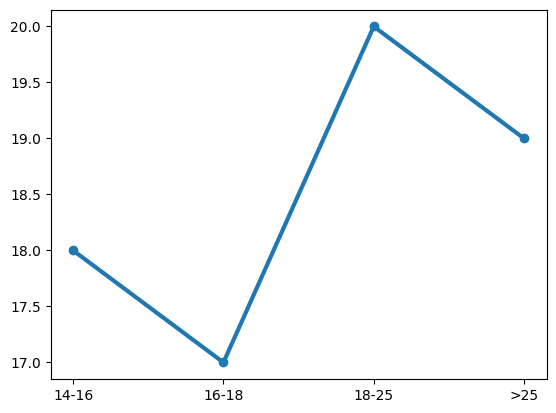

In [495]:
# Track the popularity of travelling through the age ranges

age_ranges = df.groupby('age')['activities'].apply(lambda x: ';'.join(x))

# Split the activities into a list
age_ranges = age_ranges.apply(lambda x: x.split(';'))

# Remove the <14 age range because there is too little data
age_ranges = age_ranges.drop('<14')

# Count the number of times "Travelling, visiting cities and places of interest" is mentioned
beach_per_age = age_ranges.apply(lambda x: x.count('travelling, visiting cities and places of interest'))
# Count the total number of activities for each age range
total_per_age = age_ranges.apply(lambda x: len(x))

# Calculate the percentage of travelling
percentages = [int(trav / total * 100) for trav, total in zip(beach_per_age, total_per_age)]    

# Plot the popularity of travelling through the age ranges using a curved line graph with filled area
import matplotlib.pyplot as plt

plt.plot(age_ranges.index, percentages, linestyle='solid', linewidth=3, marker='o')
plt.show()

# People start travelling more as they get older.
# The boom in travelling happens between 18 and 25 years old
# People stop travelling as much after 25 probably because of work


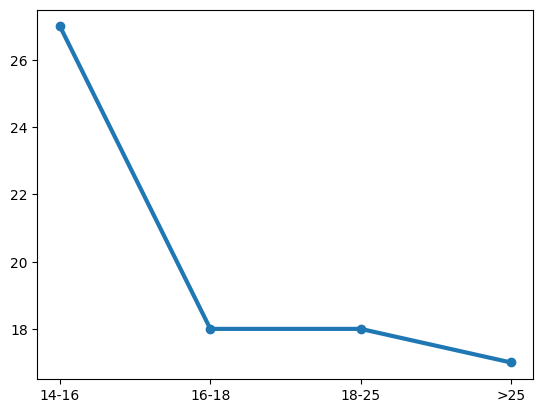

In [496]:
# Calculate the popularity of going to the beach through the age ranges

age_ranges = df.groupby('age')['activities'].apply(lambda x: ';'.join(x))

# Split the activities into a list
age_ranges = age_ranges.apply(lambda x: x.split(';'))

# Remove the <14 age range because there is too little data
age_ranges = age_ranges.drop('<14')

# Count the number of times "Travelling, visiting cities and places of interest" is mentioned
beach_per_age = age_ranges.apply(lambda x: x.count('going to the beach'))
# Count the total number of activities for each age range
total_per_age = age_ranges.apply(lambda x: len(x))

# Calculate the percentage of travelling
percentages = [int(beach / total * 100) for beach, total in zip(beach_per_age, total_per_age)]    

# Plot the popularity of travelling through the age ranges using a curved line graph with filled area
import matplotlib.pyplot as plt

plt.plot(age_ranges.index, percentages, linestyle='solid', linewidth=3, marker='o')
plt.show()

# Going to the beach becomes less popular as people get older in favor of other activities